# Jetclustering

## Configuration

In [1]:
import pandas as pd
##########################
# Define plot properties #
##########################
plot_props = pd.DataFrame({
    'dijet_m':{'name':'dijet_higgs_m','title':'Dijet Higgs Mass','xlabel':'Dijet mass [GeV]','ylabel':'Events','bins':80,'xmin':70,'xmax':150},
    'pdgid':{'name':'jets_truth','title':'Jets Truth','xlabel':'Jet truth label PDGID','ylabel':'Events','bins':16,'xmin':-8,'xmax':8},
    'recoil':{'name':'zmumu_recoil_m','title':'Recoil from Z (mass)','xlabel':'Recoil [GeV]','ylabel':'Events','bins':200,'xmin':120,'xmax':140},
    'p_ll':{'name':'zmumu_p','title':'$Z\\rightarrow \\mu^{\\plus} \\mu^{\\minus}$ Momentum','xlabel':'$p\\left( \\mu^{\\plus} \\mu^{\\minus}\\right) \\ [GeV]$','ylabel':'Events','bins':50,'xmin':20,'xmax':70},
    'm_ll':{'name':'zmumu_m','title':'$Z\\rightarrow \\mu^{\\plus} \\mu^{\\minus}$ Mass','xlabel':'$m\\left( \\mu^{\\plus} \\mu^{\\minus}\\right) \\ [GeV]$','ylabel':'Events','bins':40,'xmin':70,'xmax':110},
})
ecm=240
intLumi = 7.2e+06 #in pb-1

In [2]:
# Why pandas?
# So I can do this:
plot_props.dijet_m.title #Just looks more clean in my opinion

'Dijet Higgs Mass'

In [3]:
######################
# Define the fileset #
######################
# redirector = 'root://eospublic.cern.ch//'
redirector = ''
''' In case of problems, Download the root files from the following links:
https://prayag.web.cern.ch/share/FCC/eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root
'''
fileset = {
    'mumuHbb':{
        'files':{
            redirector+'eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root':'events'
        },
        'metadata':{
            'dataset':'wzp6_ee_mumuH_Hbb_ecm240',
            'source':'https://fcc-physics-events.web.cern.ch/fcc-ee/delphes/winter2023/idea/',
            'cross_section':0.00394, # in pb
            'comments':'H to bb',
            'label':'mumuHbb',
            'color':'red'
        }
    }
}

## The processor

In [4]:
from coffea import processor
from coffea.analysis_tools import PackedSelection, Cutflow
import awkward as ak
import dask_awkward as dak
import numpy as np
import hist.dask as hda
from collections import namedtuple
import fastjet
import hist
import vector
vector.register_awkward() # Needed to create LorentzVectors with awkward array

### Some helper functions

In [5]:
def get_1Dhist(name, var, flatten=False):
    '''
    name: eg. Zm
    var: eg. variable containing array of mass of Z
    flatten: If to flatten var before fill; False by default
    Returns a histogram
    '''
    props = plot_props[name]
    if flatten : var = dak.ravel(var) # Removes None values and all the nesting
    var = var[~dak.is_none(var, axis=0)] # Remove None values only
    return hda.Hist.new.Reg(props.bins, props.xmin, props.xmax).Double().fill(var)

def JetTruthFinder(jet_constituents, mc, findGluons = False):
    """
    Make sure that jet_constituents and mc, all have
    the same number of events.

    We have to return the PDGID of the 
    best matched genParton to the jets (by inspecting its dr with the jet constituents)

    """
    if not findGluons: #only quarks
        parton_cut = (abs(mc.PDG) <= 6)
    else: #only quarks and gluons
        parton_cut = (abs(mc.PDG) <= 6) | (abs(mc.PDG) == 21)
    
    genPartons = mc[parton_cut]
    
    jetcon_b, genParton_b = ak.unzip(ak.cartesian((jet_constituents[:,:,np.newaxis], genPartons[:,np.newaxis])))
    all_dr = jetcon_b.deltaR(genParton_b)
    sum_dr = ak.sum(all_dr, axis=3)
    min_idx = ak.argmin(sum_dr, axis=2)

    return genPartons[min_idx]

def resonanceBuilder(lepton, resonance):
    '''
    Builds Resonance candidates
    Input:    lepton(var*[var*LorentzVector]),
              resonance(float)
    Output: Reso([var*LorentzVecctor]) best resonance candidate in each event (maximum one per event)
    '''
    #Create all the combinations
    combs = ak.combinations(lepton,2)
    # Get dileptons
    lep1 , lep2 = ak.unzip(combs)
    di_lep = lep1 + lep2 # This process drops any other field except 4 momentum fields

    di_lep = ak.zip({"px":di_lep.px,"py":di_lep.py,"pz":di_lep.pz,"E":di_lep.E,"charge":lep1.charge + lep2.charge}, with_name="Momentum4D")

    # Sort by closest mass to the resonance value
    sort_mask = ak.argsort(abs(resonance-di_lep.mass), axis=1)
    Reso = di_lep[sort_mask]

    #Choose the best candidate
    Reso = ak.fill_none(Reso,[],axis=0) #Transform the None values at axis 0 to [], so that they survive the next operation
    Reso = ak.firsts(Reso) #Chooses the first elements and flattens out, [] gets converted to None

    return Reso

def recoilBuilder(vec, ecm):
    '''
    Builds Recoil from a given LorentzVector and Center of Mass Energy
    Input:    vec(var*[var*LorentzVector]),
              ecm(float)
    Output: Recoil([var*LorentzVecctor])
    '''
    Recoil = ak.zip({"px":0.0-vec.px,"py":0.0-vec.py,"pz":0.0-vec.pz,"E":ecm-vec.E},with_name="Momentum4D")
    return Recoil

def remove(array, index):
    '''
    Returns all the particles except the indices defined in index.
    Eg. remove(events.ReconstructedParticle, events.Muonidx0) returns the events.ReconstructedParticle array with all the muons removed
    '''
    all_index = ak.local_index(array,axis=1)

    n1,n2 = ak.unzip(ak.cartesian([index[:,np.newaxis] ,all_index], nested=True))
    which_ones_match = (n1 == n2)
    reduced = ak.firsts(which_ones_match)
    sum_array = ak.sum(reduced, axis=2)
    matched_mask = (sum_array == 1)
    inverse_matched_mask = ~matched_mask

    return array[inverse_matched_mask]

# Custom Recombiners
class E0_scheme:
    '''
    E0 Scheme Recombiner
    Find the C++ equivalent at https://github.com/HEP-FCC/FCCAnalyses/blob/master/addons/FastJet/src/ExternalRecombiner.cc
    '''
    def preprocess(p):
        pass
    def recombine(pa, pb):
        psum = pa+pb
        pmag = np.sqrt(psum.px()**2 + psum.py()**2 + psum.pz()**2)
        E0scale = psum.E() / pmag
        psum.reset(
                psum.px()*E0scale,
                psum.py()*E0scale,
                psum.pz()*E0scale,
                psum.E()
        )
        del pa
        del pb
        del pmag
        del E0scale
        return psum

### The processor definition

In [6]:
#################################
#Begin the processor definition #
#################################
class jetclustering(processor.ProcessorABC):
    '''
    Processor: Define actual calculations here
    '''
    def __init__(self, *args, **kwargs):
        pass

    def process(self,events):
        
        # Object Selections
        Muons = events.ReconstructedParticles[events.Muonidx0.index]
        sel_muon_p_gt_25 = Muons.p > 25.0
        Muons = Muons[sel_muon_p_gt_25]
        Z = resonanceBuilder(Muons, 91.0)
        Recoil = recoilBuilder(Z, 240.0)
        
        #Event Selections
        cuts = PackedSelection()
        cuts.add("n_gte_2_Muons", ak.num(Muons, axis=1) >= 2 )
        cuts.add("m_gt_70_Z", Z.m > 70.0 )
        cuts.add("m_lt_100_Z", Z.m < 100.0 )
        cuts.add("p_gt_20_Z", Z.p > 20.0 )
        cuts.add("p_lt_70_Z", Z.p < 70.0 )
        cuts.add("m_gt_120_Recoil", Recoil.m > 120.0 )
        cuts.add("m_lt_140_Recoil", Recoil.m < 140.0 )

        # Apply the event selections
        Good_Z = Z[cuts.all()]
        Good_Recoil = Recoil[cuts.all()]
        
        # The remove function removes those matched indices provided as argument 2
        # To remove muons with p greater than 25, we have to use that cut on indices
        # before passing on to the remove function
        high_p_muon_indices = events.Muonidx0.index[sel_muon_p_gt_25]
        rps_no_mu = remove(events.ReconstructedParticles, high_p_muon_indices)
        rps_no_mu = rps_no_mu[cuts.all()] #Apply all the event selections
        pseudo_jets = ak.zip(
            {
            'px':rps_no_mu.px,
            'py':rps_no_mu.py,
            'pz':rps_no_mu.pz,
            'E':rps_no_mu.E
            },
            with_name="Momentum4D"
        )
        arg_sort_pt = ak.argsort(pseudo_jets.pt)
        jetdef = fastjet.JetDefinition0Param(fastjet.ee_kt_algorithm)
        jetdef.set_python_recombiner(E0_scheme)
        cluster = fastjet.ClusterSequence(pseudo_jets[arg_sort_pt], jetdef)
        jets = cluster.exclusive_jets(2)
        jet_constituents = cluster.exclusive_jets_constituents(2)
        dijets = ak.sum(jets, axis=1)
        quarks_matched_to_jets = JetTruthFinder(jet_constituents, events.Particle[cuts.all()])
        pdgid = quarks_matched_to_jets.PDG

        #Prepare output
        #Choose the required histograms and their assigned variables to fill
        names = plot_props.columns.to_list()
        vars_sel = [
            dijets.m,
            ak.ravel(pdgid),
            Good_Recoil.m,
            Good_Z.p,
            Good_Z.m,
        ]
        sel_ocl = cuts.cutflow(*cuts.names).yieldhist()

        Output = {
            'histograms': {
                'sel':{name:get_1Dhist(name,var,flatten=False) for name,var in zip(names,vars_sel)},
            },
            'cutflow': {
                'sel': {'Onecut':sel_ocl[0],'Cutflow':sel_ocl[1],'Labels':sel_ocl[2]},
            },
            'metadata': events.metadata
        }
        
        # del jet_constituents
        # del jets
        # del dijets
        # del cluster
        # del jetdef
        # del rps_no_mu
        # del pseudo_jets
        # del Good_Z
        # del Good_Recoil

        return Output

    def postprocess(self, accumulator):
        pass

## Run the processor

In [7]:
from coffea import util
from coffea.nanoevents import FCC
from coffea.dataset_tools import apply_to_fileset,max_chunks,preprocess
import dask
from dask.diagnostics import ProgressBar

/home/prayag/coffeafcc/development/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [8]:
# Preprocess the fileset
dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=50_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

In [9]:
# Build the dask taskgraph
to_compute = apply_to_fileset(
        jetclustering(),
        max_chunks(dataset_runnable, 2),
        schemaclass=FCC.get_schema('pre-edm4hep1'),
        uproot_options={"filter_name": lambda x : "PARAMETERS" not in x}
    )

/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:224: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:232: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:232: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:224: UserWarning: Skipping _floatMap as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:232: UserWarning: Skipping _floatMap.first as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:232: UserWarning: Skipping _floatMap.second as it is not interpretable by Uproot
  warnings.warn(
/home/prayag/coffeafcc/development/coffea/src/coffea/util.py:224: Us

In [10]:
# Process
pgb = ProgressBar()
with pgb:
    (out,) = dask.compute(to_compute)

[########################################] | 100% Completed | 306.66 ms
[##################################      ] | 87% Completed | 3.97 sms#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#-----

[########################################] | 100% Completed | 71.02 s


In [11]:
out

{'mumuHbb': {'histograms': {'sel': {'dijet_m': Hist(Regular(80, 70, 150, label='Axis 0'), storage=Double()) # Sum: 81975.0 (82636.0 with flow),
    'pdgid': Hist(Regular(16, -8, 8, label='Axis 0'), storage=Double()) # Sum: 165272.0,
    'recoil': Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # Sum: 82636.0,
    'p_ll': Hist(Regular(50, 20, 70, label='Axis 0'), storage=Double()) # Sum: 82636.0,
    'm_ll': Hist(Regular(40, 70, 110, label='Axis 0'), storage=Double()) # Sum: 82636.0}},
  'cutflow': {'sel': {'Onecut': Hist(Integer(0, 8, name='onecut'), storage=Double()) # Sum: 729499.0,
    'Cutflow': Hist(Integer(0, 8, name='cutflow'), storage=Double()) # Sum: 714980.0,
    'Labels': ['initial',
     'n_gte_2_Muons',
     'm_gt_70_Z',
     'm_lt_100_Z',
     'p_gt_20_Z',
     'p_lt_70_Z',
     'm_gt_120_Recoil',
     'm_lt_140_Recoil']}},
  'metadata': {'dataset': 'wzp6_ee_mumuH_Hbb_ecm240',
   'source': 'https://fcc-physics-events.web.cern.ch/fcc-ee/delphes/winter2023/id

In [12]:
out['mumuHbb']['histograms']['sel']['dijet_m']

Hist(Regular(80, 70, 150, label='Axis 0'), storage=Double()) # Sum: 81975.0 (82636.0 with flow)

## Plots

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mplhep as hep
import numpy as np
import os

In [14]:
def get_xsec_scale(dataset, selection, Luminosity):
    '''
    Get final scale factor from cross section
    '''
    xsec = out[dataset]['metadata']['cross_section'] #in picobarn
    raw_events = out[dataset]['cutflow'][selection]['Cutflow'].values()[0]
    if raw_events > 0:
        sf = (xsec*Luminosity)/raw_events
    else :
        raise ValueError('Raw events less than of equal to zero!')
    return round(float(sf),3)

In [15]:
def makeplot(fig, ax, hist, name, title, label, xlabel, ylabel, bins, xmin, xmax, log, stack, color, histtype, xticks=10, cutflow_mode=False, **kwargs):
    '''
    Makes a single kinematic plot on an ax object
    '''
    hep.histplot(
        hist,
        yerr=0,
        histtype=histtype,
        label=label,
        color=color,
        alpha=0.8,
        stack=stack,
        linewidth=1,
        sort='yield_r',
        ax=ax,
        **kwargs
    )

    ax.text(0.27, 1.02, 'FCC Analyses: FCC-ee Simulation (Delphes)', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.92, 1.02, f'$\\sqrt{{s}} = {ecm} GeV$', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    if  cutflow_mode:
        ax.set_ylabel(ylabel)
    else:
        per_bin = '/'+str((xmax-xmin)/bins)
        ax.set_ylabel(ylabel+per_bin+' [GeV]')
        plt.xlim([xmin,xmax])
        plt.xticks(np.linspace(xmin,xmax,xticks+1))
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_xlabel(xlabel)

    if log :
        ax.set_yscale('log')
        plt.tick_params(axis='y', which='minor')
    else:
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.set_title(title,pad=25,  fontsize= "15", color="#192655")

In [16]:
def plot(hists, selections, save_path, signal=[], background=[]):
    if len(signal) + len(background) == 0:
        raise FileNotFoundError('Neither Signal, nor Background found!\n Aborting ...')
    else:
        for s in signal:
            if s not in out.keys():
                raise FileNotFoundError(f'{s} is not in the output : {list(out.keys())}')
        for b in background:
            if b not in out.keys():
                raise FileNotFoundError(f'{b} is not in the output : {list(out.keys())}')
    for which_selection in selections:
        for which_hist in hists:
        
            fig, ax = plt.subplots(figsize=(8,8))
            
            # Plot Backgrounds first
            if len(background) > 0:
                scaled_hists_background = [
                    out[key]['histograms'][which_selection][which_hist]*get_xsec_scale(key,which_selection,intLumi)
                    for key in out.keys()
                    if key in background
                ]
    
                labels_background = [
                    out[key]['metadata']['label'] 
                    for key in out.keys()
                    if key in background
                ]
    
                colors_background = [
                    out[key]['metadata']['color'] 
                    for key in out.keys()
                    if key in background
                ]
                
                makeplot(
                    fig,
                    ax,
                    scaled_hists_background,
                    **plot_props[which_hist].to_dict(),
                    label=labels_background,
                    log=False,
                    stack=True,
                    color=colors_background,
                    histtype='fill',
                    edgecolor='black'
                )
                
                
            if len(signal) > 0 :
                scaled_hists_signal = [
                    out[key]['histograms'][which_selection][which_hist]*get_xsec_scale(key,which_selection,intLumi)
                    for key in out.keys()
                    if key in signal
                ]
    
                labels_signal = [
                    out[key]['metadata']['label'] 
                    for key in out.keys()
                    if key in signal
                ]
    
                colors_signal = [
                    out[key]['metadata']['color'] 
                    for key in out.keys()
                    if key in signal
                ]

                print(scaled_hists_signal)

                if len(background) > 0:
                    signal_on_top_of_all_backgrounds = [h+sum(scaled_hists_background) for h in scaled_hists_signal] #Manual stacking because independent stacking is not supported in mplhep
                else:
                    signal_on_top_of_all_backgrounds = scaled_hists_signal                    
    
                makeplot(
                    fig,
                    ax,
                    signal_on_top_of_all_backgrounds,
                    **plot_props[which_hist].to_dict(),
                    label=labels_signal,
                    log=False,
                    stack=False,
                    color=colors_signal,
                    histtype='step'
                )
            # Then plot signal so that it sits on top of the background
            ax.legend();
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            fig.savefig(save_path+'/'+which_selection+'_'+which_hist+'.png', dpi=240)

In [17]:
# Can declare a subset of histograms that we need
Required_hists = ['dijet_m','pdgid','recoil','p_ll','m_ll']
Required_selections = ['sel']
signal = ['mumuHbb']
background = []
save_path = 'output_jet_clustering'

[Hist(Regular(80, 70, 150, label='Axis 0'), storage=Double()) # Sum: 23280.899999999998 (23468.623999999996 with flow)]
[Hist(Regular(16, -8, 8, label='Axis 0'), storage=Double()) # Sum: 46937.248]
[Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # Sum: 23468.624]
[Hist(Regular(50, 20, 70, label='Axis 0'), storage=Double()) # Sum: 23468.624]
[Hist(Regular(40, 70, 110, label='Axis 0'), storage=Double()) # Sum: 23468.624]


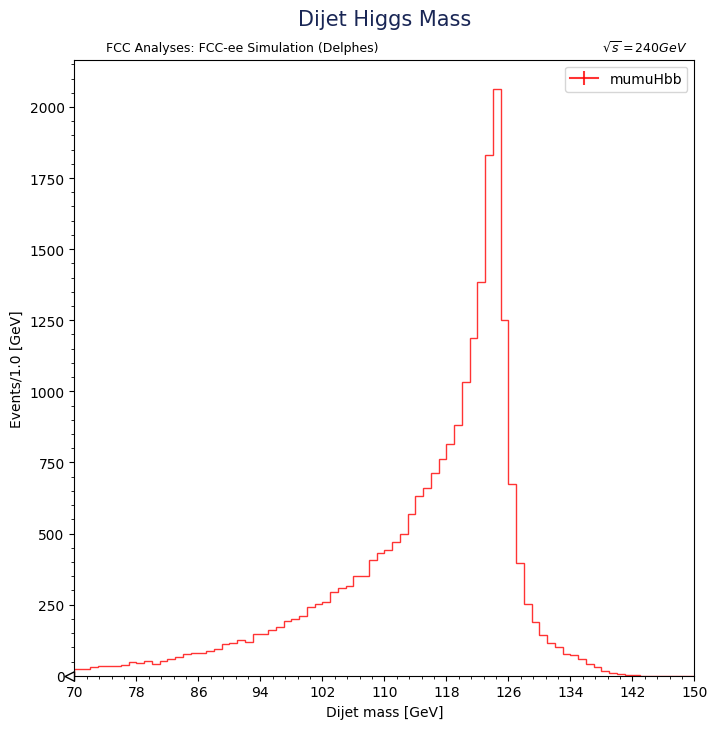

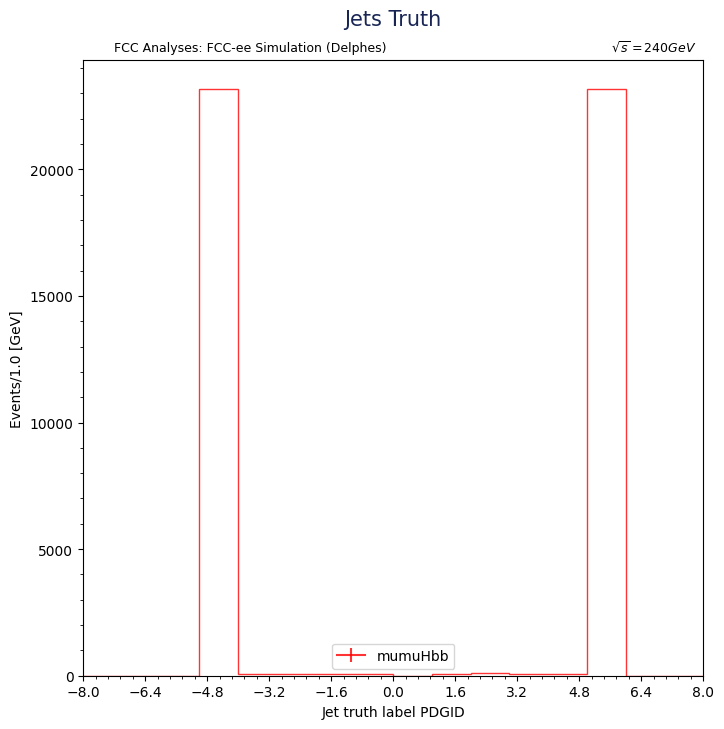

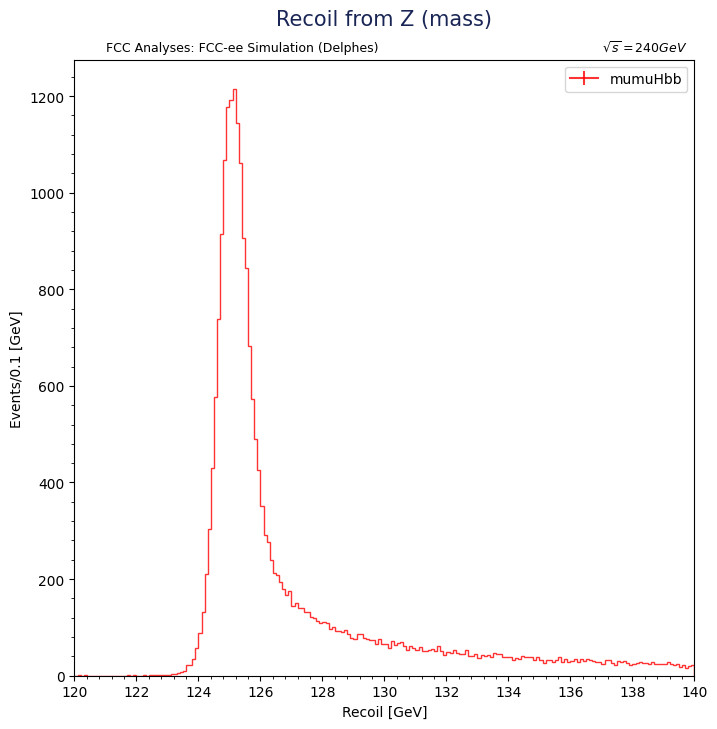

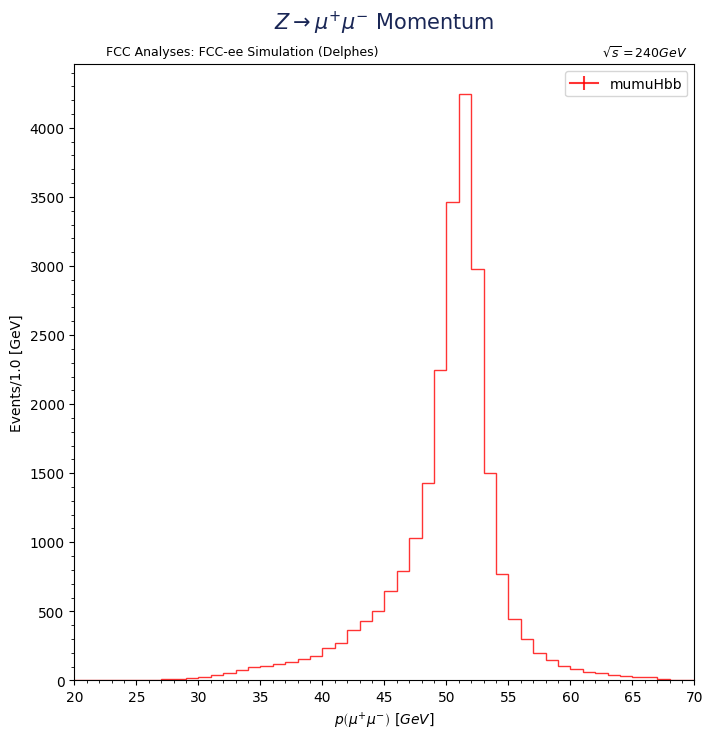

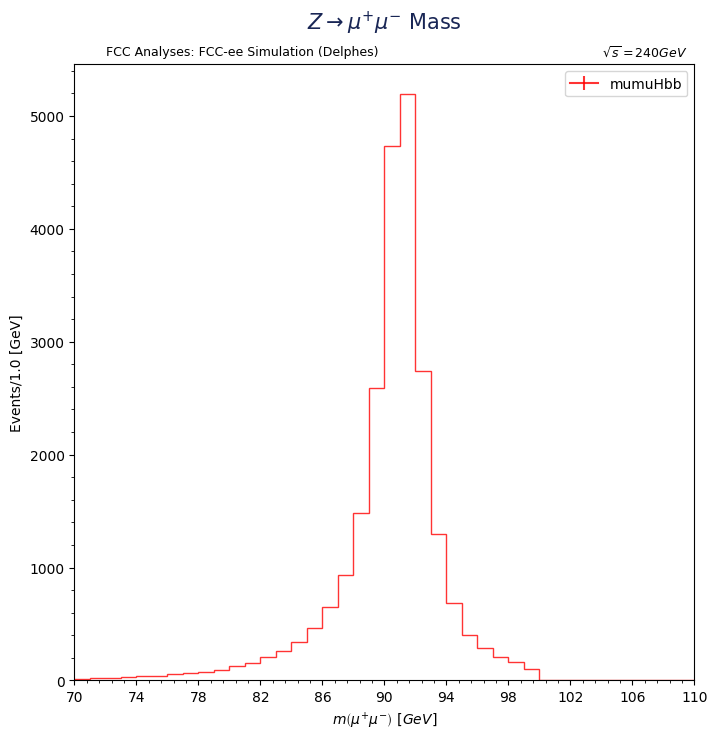

In [18]:
plot(Required_hists, Required_selections, save_path, signal, background)